# CC3084 – Data Science — **Laboratorio 5: RNN (LSTM) para Series de Tiempo**

**Serie:** *Industrial Production: Ice cream and frozen dessert (IPN31152N)*  
**Fuente:** FRED (Federal Reserve Bank of St. Louis) — https://fred.stlouisfed.org/series/IPN31152N

**Integrantes**
- Sofia Velasquez, 22049
- Jose Marchena, 22398

<a hhref="https://github.com/Sofiamishel2003/RNN_para_Series_de_Tiempo">**Repositorio**</a>

## 0) Preparación del entorno


In [1]:
%pip install -q pandas numpy matplotlib pandas_datareader

Note: you may need to restart the kernel to use updated packages.


## 1) Carga y exploración de datos

La serie **IPN31152N** está en FRED. Intentaremos descargarla con `pandas_datareader`.  


            produccion
DATE                  
2000-01-01     93.6497
2000-02-01    111.6591
2000-03-01    125.4885
2000-04-01    136.9998
2000-05-01    136.0725
       produccion
count  306.000000
mean   118.699614
std     24.802970
min     68.060900
25%    102.267825
50%    116.391150
75%    132.100425
max    196.817400


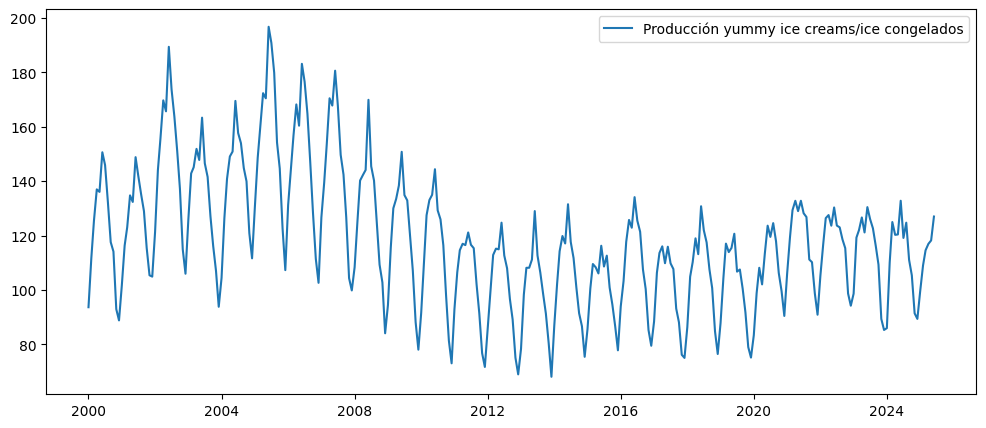

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

# Descargar datos de FRED
series = web.DataReader("IPN31152N", "fred", start, end)

series.rename(columns={"IPN31152N": "produccion"}, inplace=True) # Renombrar columna

# Visualizar primeros datos
print(series.head())
print(series.describe())
plt.figure(figsize=(12,5))
plt.plot(series, label="Producción yummy ice creams/ice congelados")
plt.legend()
plt.show()

## 2) División de conjuntos

Usaremos los **últimos 24 meses** como conjunto de prueba. El resto será entrenamiento.


Entrenamiento: (282, 1)
Prueba: (24, 1)


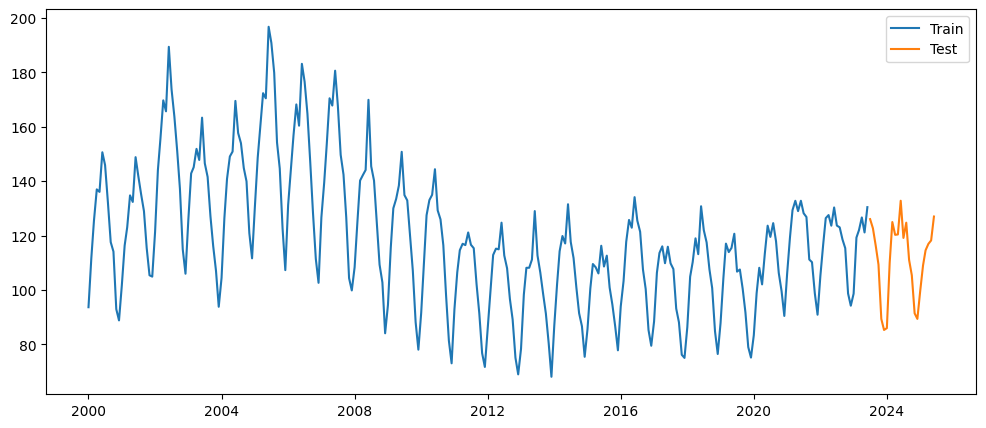

In [3]:
# Definir tamaño de prueba (24 meses)
train = series.iloc[:-24]
test = series.iloc[-24:]

print("Entrenamiento:", train.shape)
print("Prueba:", test.shape)

plt.figure(figsize=(12,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.legend()
plt.show()

## 3) Normalización y preparación

Aplicamos `MinMaxScaler` . Luego construimos un `TimeSeriesGenerator`.
- `batch_size` tamaño del lote de entrenamiento.


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
datos_entreno_escalados = scaler.transform(train)
datos_prueba_escalados = scaler.transform(test)

La longitud se basa en que estos datos son anuales por lo que se debe escoger un número de meses igual o aproximado a el número de meses en el año. Con series de tiempo, una buena práctica es seleccionar tandas de una secuencia


In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
longitud = 12
batch_size = 1
train_gen = TimeseriesGenerator(datos_entreno_escalados, 
                                datos_entreno_escalados,
                                length = longitud, 
                                batch_size = batch_size)
X,y = train_gen[0]
print(f'Dado el arreglo: \n{X.flatten()}')
print(f'Predecir esta y: \n {y}')

Dado el arreglo: 
[0.19873793 0.3386097  0.44601709 0.53542074 0.52821877 0.64139286
 0.60487199 0.49884006 0.38464388 0.35774427 0.19325704 0.16112274]
Predecir esta y: 
 [[0.26127458]]


In [83]:
val_gen = TimeseriesGenerator(datos_prueba_escalados,
                              datos_prueba_escalados, 
                              length = longitud, 
                              batch_size = batch_size)

## 4) Construccion del Modelo


In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import regularizers

epochs = 10
# Define
lstm_model = Sequential([
    LSTM(
        32, 
        return_sequences=True,
        input_shape=(longitud,1),
        kernel_regularizer=regularizers.l2(0.0001),      # L2 on input weights
        recurrent_regularizer=regularizers.l2(0.0001),
    ),
    LSTM(
        16, 

    ),
    Dense(1) # Output
])


## 5) Entrenamiento y evaluación: 
Entrenen, documenten pérdidas y realicen predicciones

Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0347
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0285
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0227
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0162
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0118
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0090
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0085
Epoch 8/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0083
Epoch 9/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0080
Epoch 10/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0076


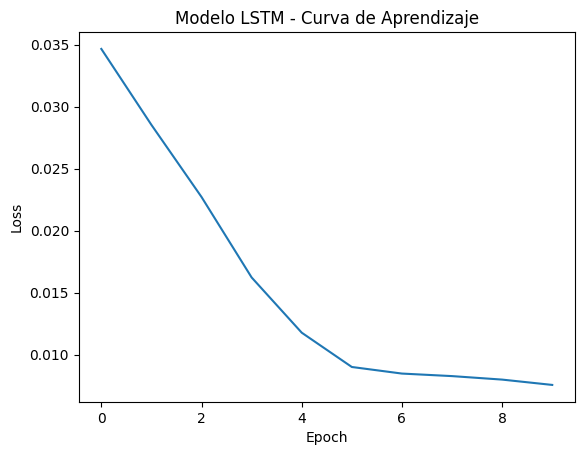

In [96]:
from matplotlib import pyplot as plt
import numpy as np

lstm_model.compile(optimizer='adam', loss='mse')
history = lstm_model.fit(
    train_gen, 
    epochs=epochs,
    verbose=1
)
plt.title("Modelo LSTM - Curva de Aprendizaje")
plt.plot(np.arange(0,epochs),history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

C:\Users\JM\AppData\Local\Temp\ipykernel_12216\1843420059.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(start=train.iloc[0].name, periods=len(train), freq="M"),
C:\Users\JM\AppData\Local\Temp\ipykernel_12216\1843420059.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(start=test.iloc[0].name, periods=len(test), freq="M"),
C:\Users\JM\AppData\Local\Temp\ipykernel_12216\1843420059.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(start=test.iloc[0].name, periods=len(y_pred), freq="M"),


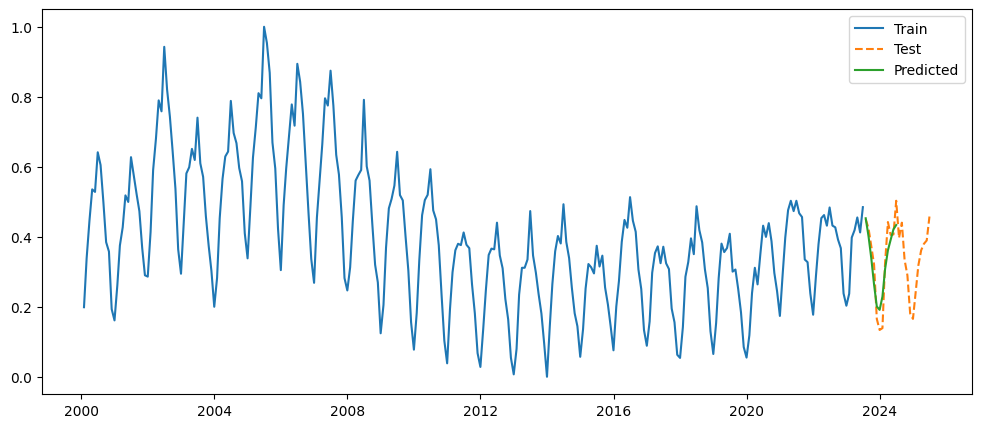

In [97]:

y_pred = lstm_model.predict(val_gen, verbose=0)

plt.figure(figsize=(12,5))
plt.plot(
    pd.date_range(start=train.iloc[0].name, periods=len(train), freq="M"),
    datos_entreno_escalados, 
    label="Train"
)
plt.plot(
    pd.date_range(start=test.iloc[0].name, periods=len(test), freq="M"),
    datos_prueba_escalados, 
    label="Test",
    linestyle='--'
)
plt.plot(
    pd.date_range(start=test.iloc[0].name, periods=len(y_pred), freq="M"),
    y_pred,
    label="Predicted"
)
plt.legend()
plt.show()